In [2423]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
 
from statsmodels.api import OLS, add_constant
import pandas_datareader.data as web
from pandas_datareader.famafrench import get_available_datasets
import yfinance as yf
import datetime as dt

from linearmodels.asset_pricing import LinearFactorModel

## Application: Return Attribution

### Download Data

In [2424]:
# 2020~2023 Monthly returns
ff_factor = 'F-F_Research_Data_5_Factors_2x3'
end = dt.datetime.now()
ff_factor_data = web.DataReader(ff_factor, 'famafrench', start='2020-04', end=end)[0]
end_date = ff_factor_data.iloc[-1].name
ff_factor_data.index = ff_factor_data.index.to_timestamp()

start='2020-03-01'
end=end_date.to_timestamp() + dt.timedelta(days=30)
All_returns = yf.download(tkrs_union, 
                          start=start, 
                          end=end, 
                          interval='1mo', progress=False)['Adj Close'].pct_change(1).dropna() * 100

sp_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500_constituents = pd.read_html(sp_url, header=0)[0]
industry_df = pd.DataFrame([(tkr[0], tkr[2], tkr[3]) for tkr in sp500_constituents.values if tkr[0] in tkrs_union], 
             columns = ['all_tkrs','GICS_Sector','GICS_Sub_Industry']).set_index('all_tkrs')

### Portfolio and Benchmark Returns
$R_{Portfolio} = \sum_{i=1}^{N}w_{p,i}R_{p,i},\ N = $ Number of stocks in portfolio

$R_{Benchmark} = \sum_{i=1}^{M}w_{b,i}R_{b,i},\ M = $ Number of stocks in benchmark

#### This attribution process assumes that the specified weight of the portfolios stays constant over time

In [2425]:
# specifying PF weights and BM weights (assume equal weighted)
## Portfolio tickers
PF_tkrs = ['AAPL','O','NVDA','MSFT','DIS','GOOGL','PYPL']
# BM tickers: SPYG ETF Top 20 constituents
BM_tkrs = ['AAPL','MSFT','NVDA','GOOGL','TSLA','GOOG','AMZN','XOM','LLY','UNH',
              'V','MA','CVX','MRK','ABBV','PEP','JNJ','AVGO','PG','TMO']
tkrs_union = list(set(BM_tkrs) | set(PF_tkrs))
PF_w = {
    'O': 0.26, 
    'NVDA': 0.23,
    'AAPL': 0.19, 
    'MSFT': 0.17,
    'DIS': 0.06, 
    'GOOGL': 0.05, 
    'PYPL': 0.04 
}

spyg_top20 = {
    'AAPL': 0.1345,
    'MSFT': 0.0769,
    'NVDA': 0.0587,
    'GOOGL': 0.0387,
    'GOOG': 0.0333,
    'TSLA': 0.0312,
    'AMZN': 0.0293,
    'UNH': 0.024,
    'LLY': 0.0228,
    'XOM': 0.0205,
    'V': 0.0193,
    'MA': 0.0161,
    'MRK': 0.0125,
    'CVX': 0.0124,
    'ABBV': 0.0118,
    'AVGO': 0.0117,
    'PEP': 0.0111,
    'JNJ': 0.0108,
    'PG': 0.0095,
    'TMO': 0.0087  
}
BM_w = dict(zip(spyg_top20.keys(), [val/ sum(spyg_top20.values()) for val in spyg_top20.values()]))

def weightings(PF_tkrs, BM_tkrs, PF_w, BM_w=None):
    tkrs_union = list(set(BM_tkrs) | set(PF_tkrs))
    print(f'Portfolio assets not included in Benchmark: {set(PF_tkrs) - set(BM_tkrs)}')
    
    # portfolios' asset weightings
    weights_df = pd.DataFrame(tkrs_union, columns=['all_tkrs'])
    
    if sum(list(PF_w.values())) != 1:
        print(f'specified PF sum != 1: {sum(list(PF_w.values()))}')
    else:
        print('specified PF sum == 1')
        weights_df['PF_w'] = weights_df.all_tkrs.apply(lambda x: PF_w[x] if x in PF_tkrs else 0)
        if BM_w == None:
            # equal weighted if not specified otherwise
            weights_df['BM_w'] = weights_df.all_tkrs.apply(lambda x: 1/len(BM_tkrs) if x in BM_tkrs else 0)
        else:
            weights_df['BM_w'] = weights_df.all_tkrs.apply(lambda x: BM_w[x] if x in BM_tkrs else 0)
        weights_df = weights_df.set_index('all_tkrs')
        
        if ((weights_df.sum()['PF_w'].astype(int) == 1) & (weights_df.sum()['BM_w'].astype(int) == 1)):
            print('both PM and BM weight sum == 1')
        else:
            print('both PM and BM weight sum!= 1')
            print(f'PM weight sum: {weights_df.sum().PF_w}')
            print(f'BM weight sum: {weights_df.sum().BM_w}')
    return weights_df

weights_df = weightings(PF_tkrs, BM_tkrs, PF_w, BM_w)
# calculate active weight = PF weights - BM weights
weights_df['a_w'] = weights_df.PF_w - weights_df.BM_w
weights_df = weights_df.join(industry_df[['GICS_Sector']])
weights_df.T

Portfolio assets not included in Benchmark: {'O', 'DIS', 'PYPL'}
specified PF sum == 1
both PM and BM weight sum == 1


all_tkrs,MA,JNJ,GOOG,LLY,MSFT,O,V,GOOGL,TSLA,PEP,...,NVDA,DIS,MRK,ABBV,AAPL,AVGO,TMO,AMZN,PYPL,XOM
PF_w,0.0,0.0,0.0,0.0,0.17,0.26,0.0,0.05,0.0,0.0,...,0.23,0.06,0.0,0.0,0.19,0.0,0.0,0.0,0.04,0.0
BM_w,0.027114,0.018188,0.056079,0.038397,0.129505,0.0,0.032503,0.065173,0.052543,0.018693,...,0.098855,0.0,0.021051,0.019872,0.226507,0.019704,0.014651,0.049343,0.0,0.034523
a_w,-0.027114,-0.018188,-0.056079,-0.038397,0.040495,0.26,-0.032503,-0.015173,-0.052543,-0.018693,...,0.131145,0.06,-0.021051,-0.019872,-0.036507,-0.019704,-0.014651,-0.049343,0.04,-0.034523
GICS_Sector,Financials,Health Care,Communication Services,Health Care,Information Technology,Real Estate,Financials,Communication Services,Consumer Discretionary,Consumer Staples,...,Information Technology,Communication Services,Health Care,Health Care,Information Technology,Information Technology,Health Care,Consumer Discretionary,Financials,Energy


### Calculating Active Returns
#### 1. Active Returns = Potfolio Returns - Benchmark Returns

$Active\ Return (R_{Active}) = R_{Portfolio} - R_{Benchmark}$

$= \sum_{i=1}^{N}w_{p,i}R_{p,i} - \sum_{i=1}^{M}w_{b,i}R_{b,i}$

#### 2. Active Returns = Active weights * Individual Asset Returns

$Active\ weights = \sum_{i}^{U}(w_{p,i} - w_{b,i})$ (portfolio's deviations from benchmark weights)

$Active\ Return = \sum_{i}^{U}(w_{p,i} - w_{b,i})R_{i},\ U$ = All ticker in Portfolio and Benchmark (union of N and M)

### Active risk
$Active\ Risk = \sigma_{(R_{Portfolio} - R_{Benchmark})} =$ Tracking Error 

### Information Ratio
$Information\ Ratio = \frac{R_{p} - R_{b}}{\sigma_{(R_{p} - R_{b})}}$

In [2426]:
# weighted returns of PF and BM
wRpi = All_returns * weights_df.PF_w
wRbi = All_returns * weights_df.BM_w
# summed weighted returns = PF and BM returns
Rp = wRpi.sum(axis=1)
Rb = wRbi.sum(axis=1)

# Active returns = Portfolio returns - Benchmark returns
# Monthly Active Returns and Risk
Ra = Rp - Rb
sigma_a = Ra.std()
IR = Ra / sigma_a

# Annualized Active Returns, risk, and IR
Ra_mean_ann = Ra.mean() * 12
Ra_geo_ann = 100 * ((1+Ra/100).prod() ** (12/len(Ra)) - 1)
sigma_a_ann = sigma_a * np.sqrt(12)

IR_mean = Ra_mean_ann / sigma_a_ann
IR_geo = Ra_geo_ann / sigma_a_ann
print(f'Annual IR (arithmetic mean): {IR_mean}')
print(f'Annual IR (geometric return): {IR_geo}')

attribution_df = pd.DataFrame([Rp, Rb, Ra, IR]).T.set_axis(['PF_ret','BM_ret', 'active_ret', 'IR'], axis=1)
# tracking benchmark but lagging on returns, underperforming

Annual IR (arithmetic mean): -0.6894840449035311
Annual IR (geometric return): -0.7075635114809504


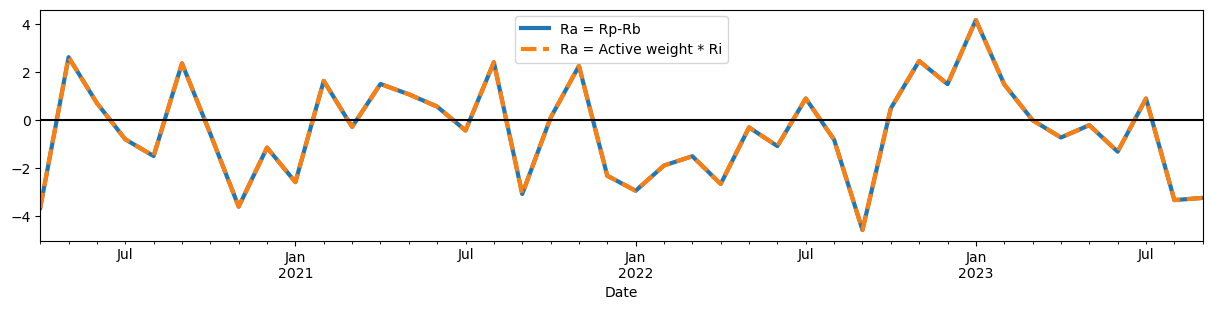

In [2427]:
# Another way to calculate active returns
ra = (All_returns * weights_df.a_w).sum(axis=1)

# check if they yield the same result
fig,ax = plt.subplots(figsize=(15,3))
Ra.plot(label='Ra = Rp-Rb', linewidth=3)
ra.plot(linestyle= '--',label='Ra = Active weight * Ri', linewidth=3)
plt.axhline(0, c='black')
plt.legend();

### Return Attribution
#### 1. Active Returns into Factor Returns and Security Selection Returns 
$Active\ Return = Factor\ Return + Security\ Selection\ Return$

##### from factor model:
$Factor\ Return = \sum_{i=1}^{k}(\beta_{p,i}-\beta_{b,i})\lambda_{i},\ \lambda_{i} = factor\ risk\ premia, k =$ Number of Factors

$Security\ Selection\ Return\ (Residuals) = Active\ Return - Factor\ Return$

In [2428]:
### Generate unsystematic risk residuals unavailable in LinearFactorModel
def FF_betas_resid(returns, ff_factor_data):
    # systematic risk described by each factors (in sensitivity of returns to factor returns)
    betas = []
    # idiosyncratic risk not explained by the factor model (in residual returns)
    residuals = pd.DataFrame(columns=returns.columns, 
                             index=ff_factor_data.index)
    for asset in returns:
        step1 = OLS(endog=returns.loc[ff_factor_data.index, asset], 
                    exog=add_constant(ff_factor_data)
                    ).fit()
        betas.append(step1.params.drop('const'))
        residuals[f'{asset}'] = step1.resid
    betas = pd.DataFrame(betas, 
                         columns=ff_factor_data.columns, 
                         index=returns.columns)
    return betas, residuals

### Generate factor risk premia that varies over time unavailable in LinearFactorModel
def FF_lambdas(returns, betas):
    lambdas = []
    for period in returns.index:
        step2 = OLS(endog=returns.loc[period, betas.index],
                    exog=add_constant(betas)
                    ).fit()
        lambdas.append(step2.params)
    lambdas = pd.DataFrame(lambdas, 
                           index=returns.index,
                           columns=step2.params.index.tolist()).rename({'const':'RF'}, axis=1)
    return lambdas

### fit factor model using LinearFactorModel
def factor_model(All_returns, ff_factor_data, tkrs):
    # convert returns to excess returns
    excess_rets = All_returns[tkrs].sub(ff_factor_data.RF, axis=0)
    ff_factors = ff_factor_data.drop('RF', axis=1)

    model = LinearFactorModel(portfolios=excess_rets, 
                              factors=ff_factors, risk_free=True) 
    res = model.fit()
    betas = res.betas
    factor_riskpremia = res.risk_premia
    return excess_rets, ff_factors, betas, factor_riskpremia

# estimate factor risk premia (lambdas), factor exposures (betas)
U_excess_rets, ff_factors, U_betas, U_factor_riskpremia = factor_model(All_returns, ff_factor_data, tkrs_union)
U_lambdas = FF_lambdas(U_excess_rets, U_betas)

PF_excess_rets, ff_factors, PF_betas, PF_factor_riskpremia = factor_model(All_returns, ff_factor_data, PF_tkrs)
PF_lambdas = FF_lambdas(PF_excess_rets, PF_betas)

BM_excess_rets, ff_factors, BM_betas, BM_factor_riskpremia = factor_model(All_returns, ff_factor_data, BM_tkrs)
BM_lambdas = FF_lambdas(BM_excess_rets, BM_betas)

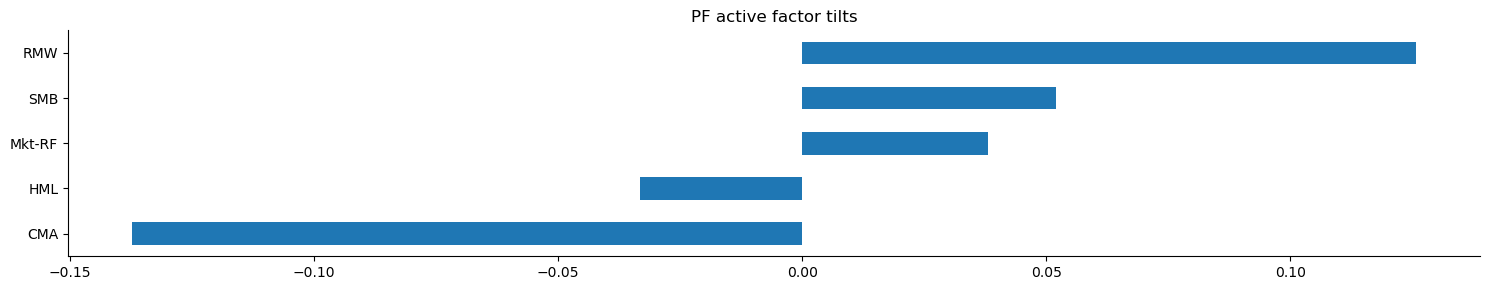

In [2429]:
# Portfolio Factor Exposure - Benchmark Factor Exposure 
# = PM's decision to take on factor exposure different from the Benchmark
# Portfolio Beta is calculated by the weighted average of stock Betas by their weights. 
factor_tilts = (PF_betas.T * weights_df.PF_w[PF_tkrs]).sum(axis=1) - (BM_betas.T * weights_df.BM_w[BM_tkrs]).sum(axis=1)

# Factor returns = sum of factor tilts * risk premia
# factor tilts multiplied by Benchmark Lambdas as factor returns only consider return deviations due to factor tilts.
factor_returns_b = (factor_tilts * BM_lambdas).sum(axis=1)
# factor tilts multiplied by Lambdas fitted on all tickers (PF + BM tickers), to make BM and PF share the same risk premia
factor_returns_u = (factor_tilts * U_lambdas).sum(axis=1)

# security selection returns = Active returns - factor returns, residual difference
stock_selection_returns_b = Ra - factor_returns_b
stock_selection_returns_u = Ra - factor_returns_u

attribution_df['factor_returns_b'] = factor_returns_b
attribution_df['stock_selection_returns_b'] = stock_selection_returns_b
attribution_df['factor_returns_u'] = factor_returns_u
attribution_df['stock_selection_returns_u'] = stock_selection_returns_u

# *** for the sake of analysis, I will use risk premia estimated 
# *** from all tickers as the common risk premia for PF and BM's factor model
# *** therefore, I will be using factor_returns_u, stock_selection_returns_u

# factor tilts visualized
factor_tilts.sort_values().plot.barh(figsize=(15, 3))
sns.despine()
plt.title('PF active factor tilts')
plt.tight_layout();

# Robust profitability, Small, high beta, growth bias, aggressive investment factor exposures relative to benchmark

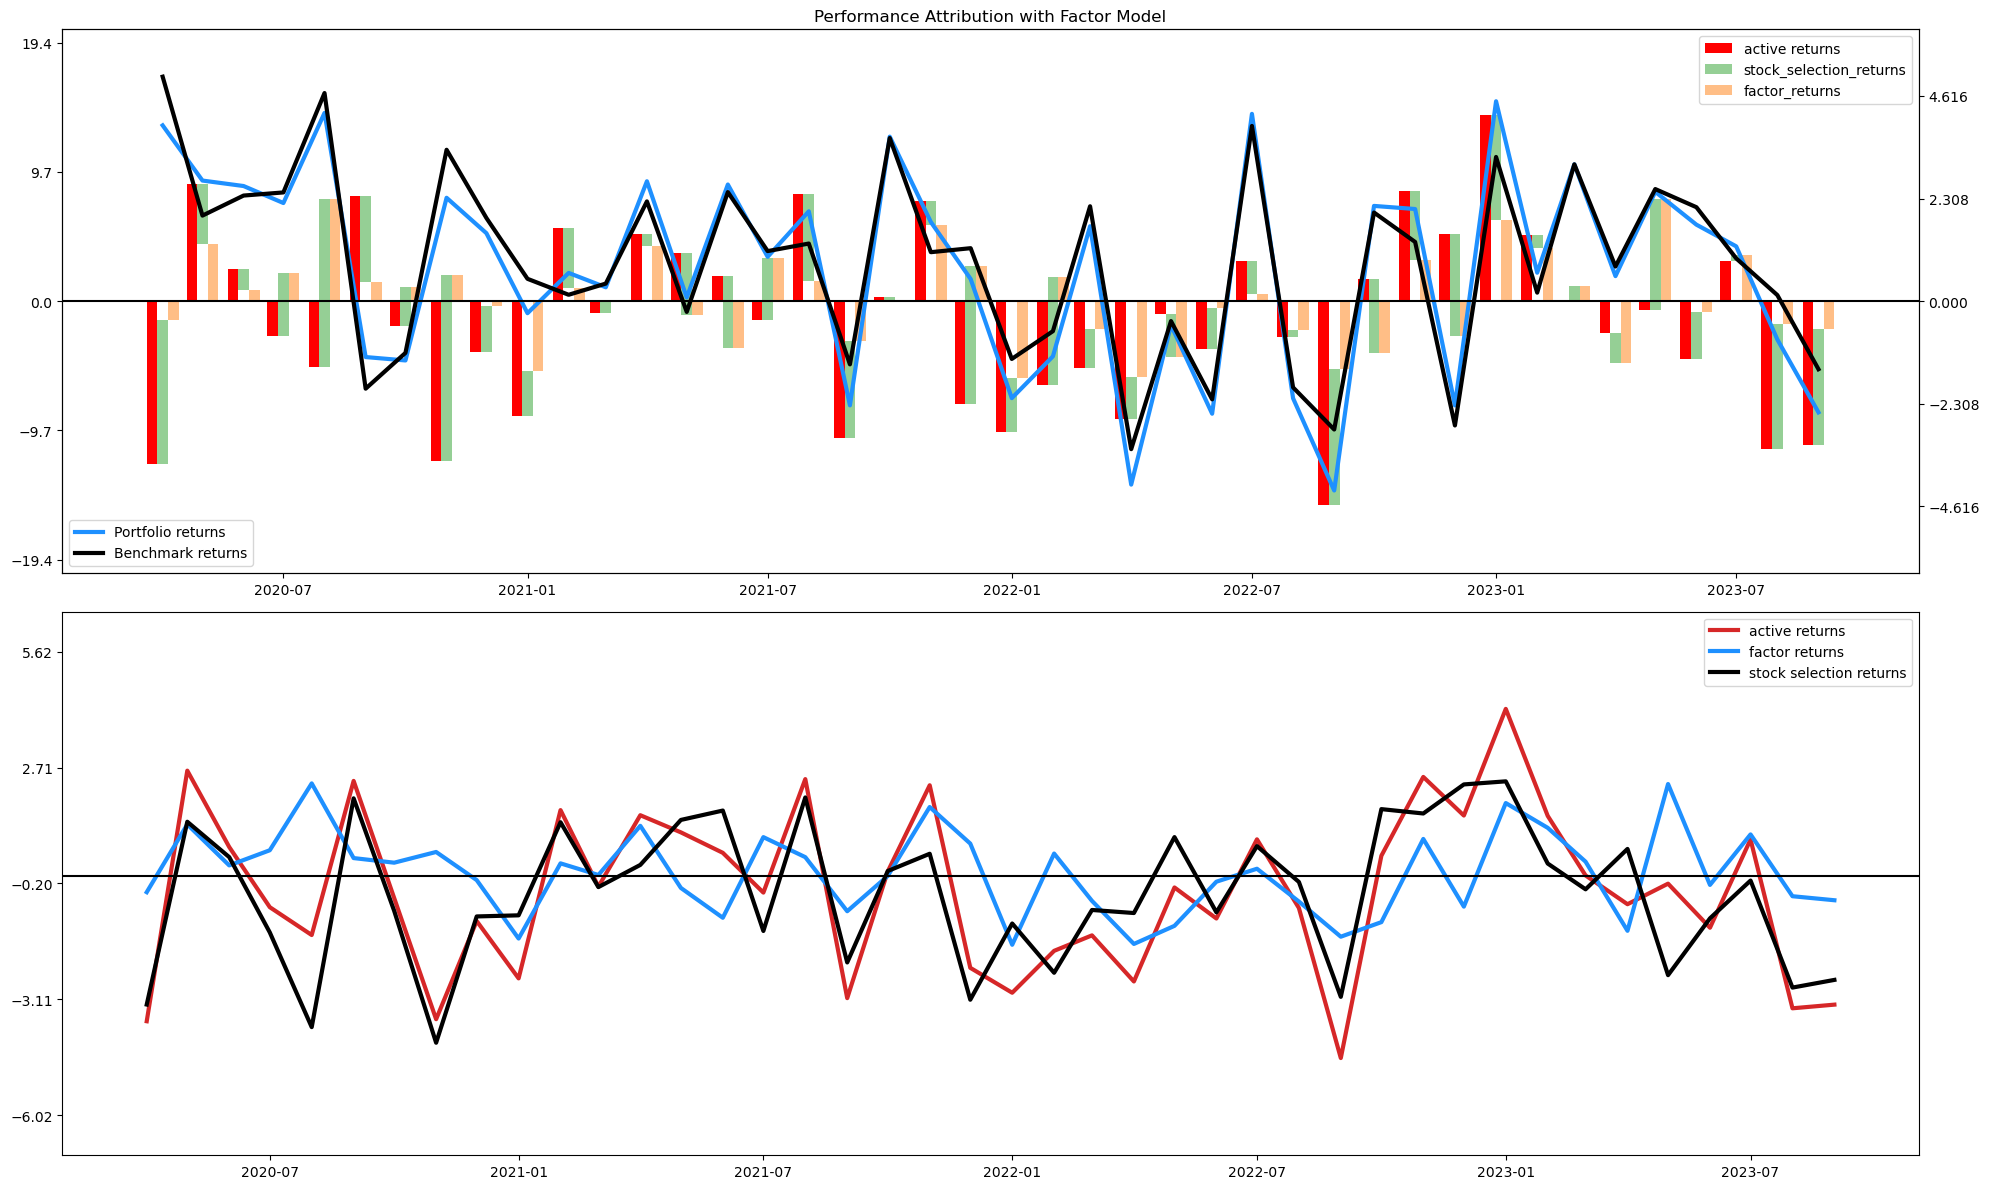

In [2430]:
fig,ax = plt.subplots(2,1, figsize=(20,12))
ax1 = ax[0].twinx()
# Portfolio and Benchmark monthly returns
ax[0].plot(Rp, label='Portfolio returns', linewidth=3, color='dodgerblue')
ax[0].plot(Rb, label='Benchmark returns', linewidth=3, color='black')

ax1.bar(x=Ra.index - dt.timedelta(8), 
        height=Ra, label='active returns', 
        width=8, color='red')

# stock_selection_returns_u, factor_returns_u or stock_selection_returns_b, factor_returns_b
ax1.bar(x=stock_selection_returns_u.index, 
        height=stock_selection_returns_u, label='stock_selection_returns', 
        bottom=factor_returns_u, 
        width=8, color='tab:green', alpha=0.5)
ax1.bar(x=factor_returns_u.index + dt.timedelta(8), 
        height=factor_returns_u, label='factor_returns', 
        width=8, color='tab:orange', alpha=0.5)

ax[1].plot(Ra, label='active returns', linewidth=3, color='tab:red')
ax[1].plot(factor_returns_u, label='factor returns', linewidth=3, color='dodgerblue')
ax[1].plot(stock_selection_returns_u, label='stock selection returns', linewidth=3, color='black');

plt.title('Performance Attribution with Factor Model')
for i in range(2):
    ax[i].axhline(0,c='black')
    ax[i].set_yticks(np.linspace(-max(abs(ax[i].get_ybound()[0]), abs(ax[i].get_ybound()[1]))-1, max(abs(ax[i].get_ybound()[0]), abs(ax[i].get_ybound()[1])+1), 5))
    ax[i].set_ylim(-max(abs(ax[i].get_ybound()[0]), abs(ax[i].get_ybound()[1]))-1, max(abs(ax[i].get_ybound()[0]), abs(ax[i].get_ybound()[1])+1))
    
    ax[i].legend();

ax1.set_yticks(np.linspace(-ax1.get_ybound()[1], ax1.get_ybound()[1], 5))
ax1.set_ylim([-ax1.get_ybound()[1]-1.5, ax1.get_ybound()[1]+1.5])
ax[0].set_zorder(ax1.get_zorder()+1)
ax[0].patch.set_visible(False)
ax[0].legend(loc='lower left');
ax1.legend();
plt.tight_layout();

In [2431]:
print('mean active return', attribution_df.active_ret.mean())
print('mean factor return', attribution_df['factor_returns_u'].mean(), '\nmean factor return proportion', attribution_df['factor_returns_u'].mean() / attribution_df.active_ret.mean())
print('mean selection return', attribution_df['stock_selection_returns_u'].mean(), '\nmean selection return proportion', attribution_df['stock_selection_returns_u'].mean() / attribution_df.active_ret.mean())
# factor exposure seem to help attain less negative(=positive) active return, current factor exposure seems ok
# selection return seem to be adversely affecting the active returns, dragging down the active returns to negative

mean active return -0.41022062979049967
mean factor return 0.06791723073353916 
mean factor return proportion -0.16556268944403063
mean selection return -0.478137860524039 
mean selection return proportion 1.165562689444031


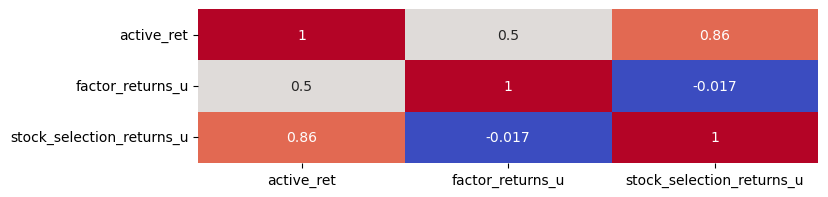

In [2432]:
# factor returns and stock selction returns correlational strength with active returns
plt.figure(figsize=(8,2))
corr_mat = attribution_df[['active_ret','factor_returns_u','stock_selection_returns_u']].corr()
sns.heatmap(corr_mat, annot=True, cbar=False, cmap='coolwarm');
# selection return seem to more strongly drag down the active returns than factor returns push up the active returns

### Risk-adjusted returns

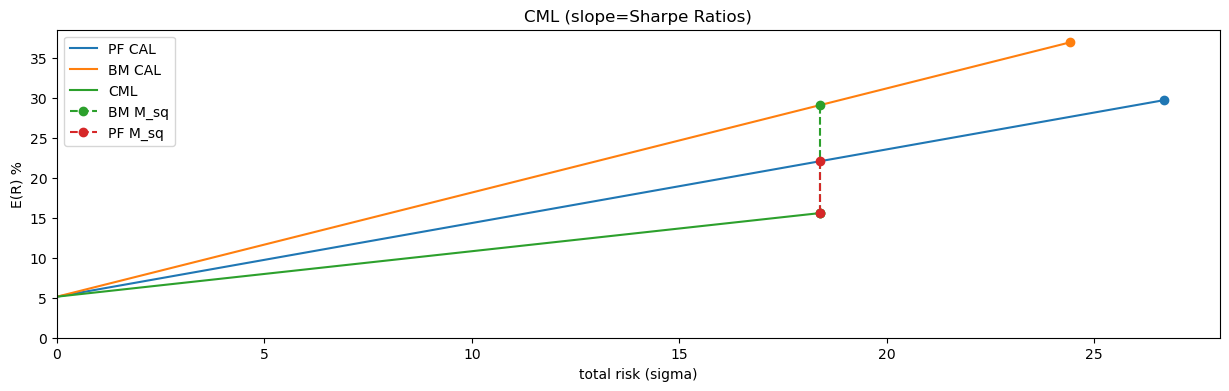

In [2433]:
# Get market index returns
Rm = yf.download(['^GSPC'], 
                 start=start, 
                 end=end, 
                 interval='1mo', progress=False)['Adj Close'].pct_change(1).dropna() * 100

# calculate annualized geometric returns for PF, BM, Market, Rf
Rp_geo = 100 * ((1+wRpi.sum(axis=1)/100).prod() ** (12/len(wRpi.sum(axis=1))) - 1)
Rb_geo = 100 * ((1+wRbi.sum(axis=1)/100).prod() ** (12/len(wRbi.sum(axis=1))) - 1)
Rm_geo = 100 * ((1+Rm/100).prod() ** (12/len(Rm)) - 1)
Rf_geo = 100 * ((1+ff_factor_data.RF/100).prod() - 1)

# calculate annualized std for PF, BM, Market
p_std = wRpi.sum(axis=1).std() * np.sqrt(12)
b_std = wRbi.sum(axis=1).std() * np.sqrt(12)
m_std = Rm.std() * np.sqrt(12)


# M-squared in pct terms 
# = unsystematic risk-adjusted returns, assuming if different PF had same total risk as Market, 
# compare excess returns over the excess Market returns
p_Msq = (Rp_geo - Rf_geo) * (m_std / p_std) - (Rm_geo - Rf_geo)
b_Msq = (Rb_geo - Rf_geo) * (m_std / b_std) - (Rm_geo - Rf_geo)
m_Msq = (Rm_geo - Rf_geo) * (m_std / m_std) - (Rm_geo - Rf_geo)


fig,ax = plt.subplots(figsize=(15,4))
ax.plot(np.linspace(0, p_std), np.linspace(Rf_geo, Rp_geo), label='PF CAL')
ax.scatter(x=p_std, y=Rp_geo)
ax.plot(np.linspace(0, b_std), np.linspace(Rf_geo, Rb_geo), label='BM CAL')
ax.scatter(x=b_std, y=Rb_geo);
ax.plot(np.linspace(0, m_std), np.linspace(Rf_geo, Rm_geo), label='CML')
ax.scatter(x=m_std, y=Rm_geo);

ax.set_ylim(0)
ax.set_xlim(0)
y_range = ax.get_ybound()[1] - ax.get_ybound()[0]
ax.axvline(x=m_std, ymin=(Rm_geo)/y_range, ymax=(Rm_geo+b_Msq)/y_range, 
           linestyle='--', marker='o', c='tab:green', label='BM M_sq')
ax.axvline(x=m_std, ymin=(Rm_geo)/y_range, ymax=(Rm_geo+p_Msq)/y_range, 
           linestyle='--', marker='o', c='tab:red', label='PF M_sq');
ax.set_title('CML (slope=Sharpe Ratios)')
ax.set_ylabel('E(R) %')
ax.set_xlabel('total risk (sigma)')
ax.legend();
# lower sharpe ratio(slope) than benchmark, with less total-risk adjusted returns(M2) than benchmark over the market index

In [2434]:
### Generate systematic risk-adjusted returns using 5 factor model
def get_alphas(All_returns, lambdas, betas):
    exp_ret = pd.DataFrame(index=lambdas.index, columns=betas.index)
    for asset in betas.index:
        exp_ret[f'{asset}'] = lambdas.RF + (betas.loc[asset] * lambdas.iloc[:,1:]).sum(axis=1)

    alphas = All_returns - exp_ret
    return exp_ret, alphas

# risk adjusted returns for each assets used for return attributions of portfolios with different betas from benchmark
# returns after systematic risk effects are removed
U_exp_ret, U_alphas = get_alphas(All_returns, U_lambdas, U_betas)

U_exp_ret, U_alphas = get_alphas(All_returns, U_lambdas, U_betas)
PF_exp_ret, PF_alphas = get_alphas(All_returns, U_lambdas, PF_betas)
BM_exp_ret, BM_alphas = get_alphas(All_returns, U_lambdas, BM_betas)
p_alphas = (PF_alphas * weights_df.PF_w).dropna(axis=1).sum(axis=1)
b_alphas = (BM_alphas * weights_df.BM_w).dropna(axis=1).sum(axis=1)
p_alpha = 100 * ((1+p_alphas/100).prod() ** (12/len(p_alphas)) - 1)
b_alpha = 100 * ((1+b_alphas/100).prod() ** (12/len(b_alphas)) - 1)

### Generate unsystematic risk-adjusted returns using M-squared method
def get_M_sqs(Rm, Ri, ff_factor_data, window = 12):
    # monthly data, rolling 1 year std
    m_std_rolling = Rm.rolling(window=window).std()
    p_std_rolling = Ri.rolling(window=window).std()
    M_sqs = (Ri - ff_factor_data.RF) * (m_std_rolling/p_std_rolling) - (Rm - ff_factor_data.RF)
    return M_sqs

p_Msqs = get_M_sqs(Rm, Rp, ff_factor_data)
b_Msqs = get_M_sqs(Rm, Rb, ff_factor_data)

In [2435]:
performance_indicators = pd.DataFrame(index=['PF','BM','M'], columns=['returns','total_risk','sharpe_ratio','M_sq','beta','treynor_ratio','jensens_alpha','IR'])
performance_indicators.returns.loc['PF'] = Rp_geo
performance_indicators.returns.loc['BM'] = Rb_geo
performance_indicators.returns.loc['M'] = Rm_geo

performance_indicators.total_risk.loc['PF'] = p_std
performance_indicators.total_risk.loc['BM'] = b_std
performance_indicators.total_risk.loc['M'] = m_std

performance_indicators.sharpe_ratio.loc['PF'] = (Rp_geo-Rf_geo) / p_std
performance_indicators.sharpe_ratio.loc['BM'] = (Rb_geo-Rf_geo) / b_std
performance_indicators.sharpe_ratio.loc['M'] = (Rm_geo-Rf_geo) / m_std

performance_indicators.M_sq.loc['PF'] = p_Msq
performance_indicators.M_sq.loc['BM'] = b_Msq
performance_indicators.M_sq.loc['M'] = m_Msq

performance_indicators.beta.loc['PF'] = np.cov(wRpi.sum(axis=1), Rm)[0,1] / np.cov(wRpi.sum(axis=1), Rm)[1,1]
performance_indicators.beta.loc['BM'] = np.cov(wRbi.sum(axis=1), Rm)[0,1] / np.cov(wRbi.sum(axis=1), Rm)[1,1]
performance_indicators.beta.loc['M'] = np.cov(Rm, Rm)[0,1] / np.cov(Rm, Rm)[1,1]

performance_indicators.treynor_ratio.loc['PF'] = (Rp_geo/100-Rf_geo/100) / performance_indicators.beta.loc['PF']
performance_indicators.treynor_ratio.loc['BM'] = (Rb_geo/100-Rf_geo/100) / performance_indicators.beta.loc['BM']
performance_indicators.treynor_ratio.loc['M'] = (Rm_geo/100-Rf_geo/100) / performance_indicators.beta.loc['M']


ERm = ff_factor_data.RF + (Rm - ff_factor_data.RF) * performance_indicators.beta.loc['M']
mkt_alphas = Rm - ERm
mkt_alpha = 100 * ((1+mkt_alphas/100).prod() ** (12/len(mkt_alphas)) - 1)

performance_indicators.jensens_alpha.loc['PF'] = p_alpha
performance_indicators.jensens_alpha.loc['BM'] = b_alpha
performance_indicators.jensens_alpha.loc['M'] = mkt_alpha

# IR is calculated relative to Benchmark, not market
Ra_m = Rm - Rb
Ra_m_geo = 100 * ((1+Ra_m/100).prod() ** (12/len(Ra_m)) - 1)
sigma_a_m = Ra_m.std() * np.sqrt(12)
IR_m = Ra_m_geo / sigma_a_m

performance_indicators.IR.loc['PF'] = IR_geo
performance_indicators.IR.loc['BM'] = 0
performance_indicators.IR.loc['M'] = IR_m

# summary of performance indicators
performance_indicators

,returns,total_risk,sharpe_ratio,M_sq,beta,treynor_ratio,jensens_alpha,IR
PF,29.676565,26.685947,0.91988,6.474486,1.301692,0.188584,-2.808575,-0.707564
BM,36.88371,24.410237,1.300889,13.478083,1.216996,0.260929,3.135495,0
M,15.563176,18.381704,0.567655,0.0,1.0,0.104345,0.0,-1.654487


### Active Risks (Tracking error)

$Active\ Risk^2 = Active\ Factor Risk^2 + Active\ Specific\ Risk^2$

$Active\ Specific\ Risk^2 = \sum_{i=1}^{N}(w_{p,i}-w_{b,i})\sigma_{e,i}^2,\ N =$ Number of stocks in Portfolio \
--> Risk from Active asset selection attributable to deviations from BM asset weightings \
e.g. PM's decision to under/over-weight **particular industries** relative to BM's weight, causing different factor sensitivities from the BM porfolio

$Active\ Factor Risk^2 = Active\ Risk^2 - Active\ Specific\ Risk^2$ \
--> Risk from Active factor tilts attributable to deviations from BM factor exposures(betas) for the same set of factors \
e.g. PM's decision to under/over-weight individual stocks **within speicifc industries**

$Active\ Factor Risk^2 = \sigma_{(R_{p} - R_{b})}^2 - \sum_{i=1}^{N}(w_{p,i}-w_{b,i})\sigma_{e,i}^2$



Active risk = 14.7149,            (100%)
Active factor risk = 0.457,         (3%)
Active specific risk = 14.2579,     (97%)



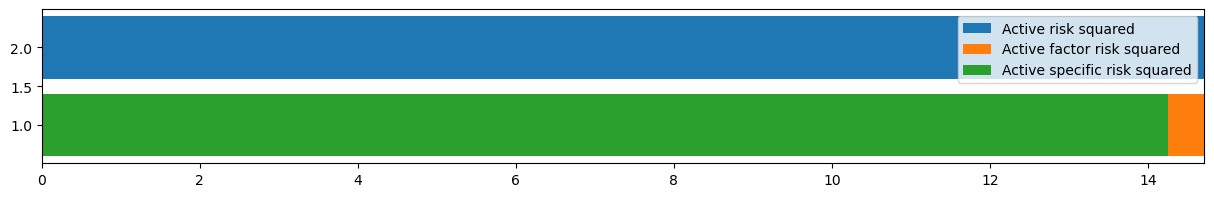

In [2436]:
# Risk on annual basis
# Active risk in squared format
Active_risk = sigma_a ** 2 * np.sqrt(12)
# Active specific risk in squared format
betas, residuals = FF_betas_resid(All_returns, ff_factor_data)
Active_specific_risk = ((active_w ** 2) * (residuals.std() ** 2)).sum() * np.sqrt(12)
# Active factor risk in squared format
Active_factor_risk = Active_risk - Active_specific_risk

print(f'''
Active risk = {round(Active_risk,4)},            ({round(100 * Active_risk/Active_risk)}%)
Active factor risk = {round(Active_factor_risk,4)},         ({round(100 * Active_factor_risk/Active_risk)}%)
Active specific risk = {round(Active_specific_risk,4)},     ({round(100 * Active_specific_risk/Active_risk)}%)
''')
fig,ax = plt.subplots(figsize=(15,2))
ax.barh(width=Active_risk, y=1+1, label='Active risk squared')
ax.barh(width=Active_specific_risk + Active_factor_risk, y=1, label='Active factor risk squared');
ax.barh(width=Active_specific_risk, y=1, label='Active specific risk squared');
ax.set_xlim([0,Active_specific_risk + Active_factor_risk])
plt.legend();

# seem to be taking on too much active specific risk and too little active factor risk

#### 2. Active Returns into Asset Allocation Returns and Security Selection Returns 
$Active\ Return = Asset\ Allocation\ Return + Security\ Selection\ Return$

$Asset\ Allocation\ Return = Active\ weights * Benchmark Returns$

$= \sum_{i=1}^{U}(w_{p,i}-w_{b,i})R_{b,i},\ U =$ All stocks in Portfolio

#### Brinson-Fachler Attribution Model
##### 1. Asset Allocation Effect 
$Asset\ Allocation\ Effect = \sum_{i=1}^{S}(w_{sp,i}-w_{sb,i})(R_{sb,i} - R_{b}),\ S =$ Number of Sectors (Classes)

$w_{sp,i}\ =$ Portfolio weights of assets within each classes/sectors, 

= PF_w / sum (PF_w of assets in same class)

$w_{sb,i}\ =$ Benchmark weights of assets within each classes/sectors, 

= BM_w / sum (BM_w of assets in same class)

$R_{sb,i}\ =$ Individual asset returns * within class/sector weights

$R_{b} =$ Benchmark return

##### 2. Security Selection Effect 
$Security\ Selection\ Effect = Portfolio\ weights * Active Returns$

$= \sum_{i=1}^{S}w_{sp,i}(R_{sp,i}-R_{sb,i}) = \sum_{i=1}^{S}w_{sp,i}(R_{sp,i} - R_{sb,i}),\ U =$ All stocks in Portfolio

##### 3. Interaction Effect 
$Interaction\ Effect = Active\ weights * Active Returns$
(residual effects)

$= \sum_{i=1}^{S}(w_{sp,i}-w_{sb,i})(R_{sp,i} - R_{sb,i})$


In [2437]:
All_returns = yf.download(tkrs_union, 
                          start=start, 
                          end=end, 
                          interval='1mo', progress=False)['Adj Close'].pct_change(1).dropna() * 100
wRpi = All_returns * weights_df.PF_w
wRbi = All_returns * weights_df.BM_w
wRai = wRpi - wRbi

Rp = wRpi.sum(axis=1)
Rb = wRbi.sum(axis=1)
Ra = wRai.sum(axis=1)

def get_sector_returns(All_returns, weights_df, pf='PF'):
    # calculate each asset's within sector/class weights = asset weight / sum(asset weights within same sector/class)
    weights_df[f'{pf}_w_within'] = weights_df[f'{pf}_w'].div(weights_df.groupby('GICS_Sector')[f'{pf}_w'].transform(sum), axis=0)
    # replace zero divisions with 0
    weights_df[f'{pf}_w_within'] = weights_df[f'{pf}_w_within'].replace({np.nan:0})
    
    # calculate within-sector/class weighted returns for each assets
    wRi_within = All_returns.mul(weights_df[f'{pf}_w_within'], axis=1)
    # sum up within-sector/class weighted returns for each classes 
    # to get each sector/class returns accounted for in the portfolio
    wRi_within = wRi_within.T.join(weights_df['GICS_Sector']) \
                             .groupby('GICS_Sector').sum()
    return wRi_within.T, weights_df

wRpi_within, weights_df = get_sector_returns(All_returns, weights_df, pf='PF')
wRbi_within, weights_df = get_sector_returns(All_returns, weights_df, pf='BM')

def get_attribution_effects(weights_df, wRpi_within, wRbi_within, Rb, model='BF'):
    sector_w = weights_df.groupby('GICS_Sector').sum()
    
    if model == 'BF':
        allocation_effect = ((sector_w.PF_w - sector_w.BM_w) * wRbi_within.sub(Rb, axis=0))
    else: # BHB model
        allocation_effect = ((sector_w.PF_w - sector_w.BM_w) * wRbi_within)
    selection_effect = (sector_w.BM_w * (wRpi_within - wRbi_within))
    interaction_effect = ((sector_w.PF_w - sector_w.BM_w) * (wRpi_within - wRbi_within))
    
    return allocation_effect, selection_effect, interaction_effect

def sector_attribution(weights_df, AAE, SSE, IE):
    sector_df = weights_df.groupby('GICS_Sector').sum()
    AAE = AAE.sum(axis=0)
    SSE = SSE.sum(axis=0)
    IE = IE.sum(axis=0)

    sector_df['AAE'] = AAE
    sector_df['SSE'] = SSE
    sector_df['IE'] = IE
    sector_df['sector_contribution'] = sector_df[['AAE','SSE','IE']].sum(axis=1)
    #sector_df['sector_contribution_pct'] = sector_df['sector_contribution'] / sector_df[['AAE','SSE','IE']].sum(axis=0).sum()
    return sector_df

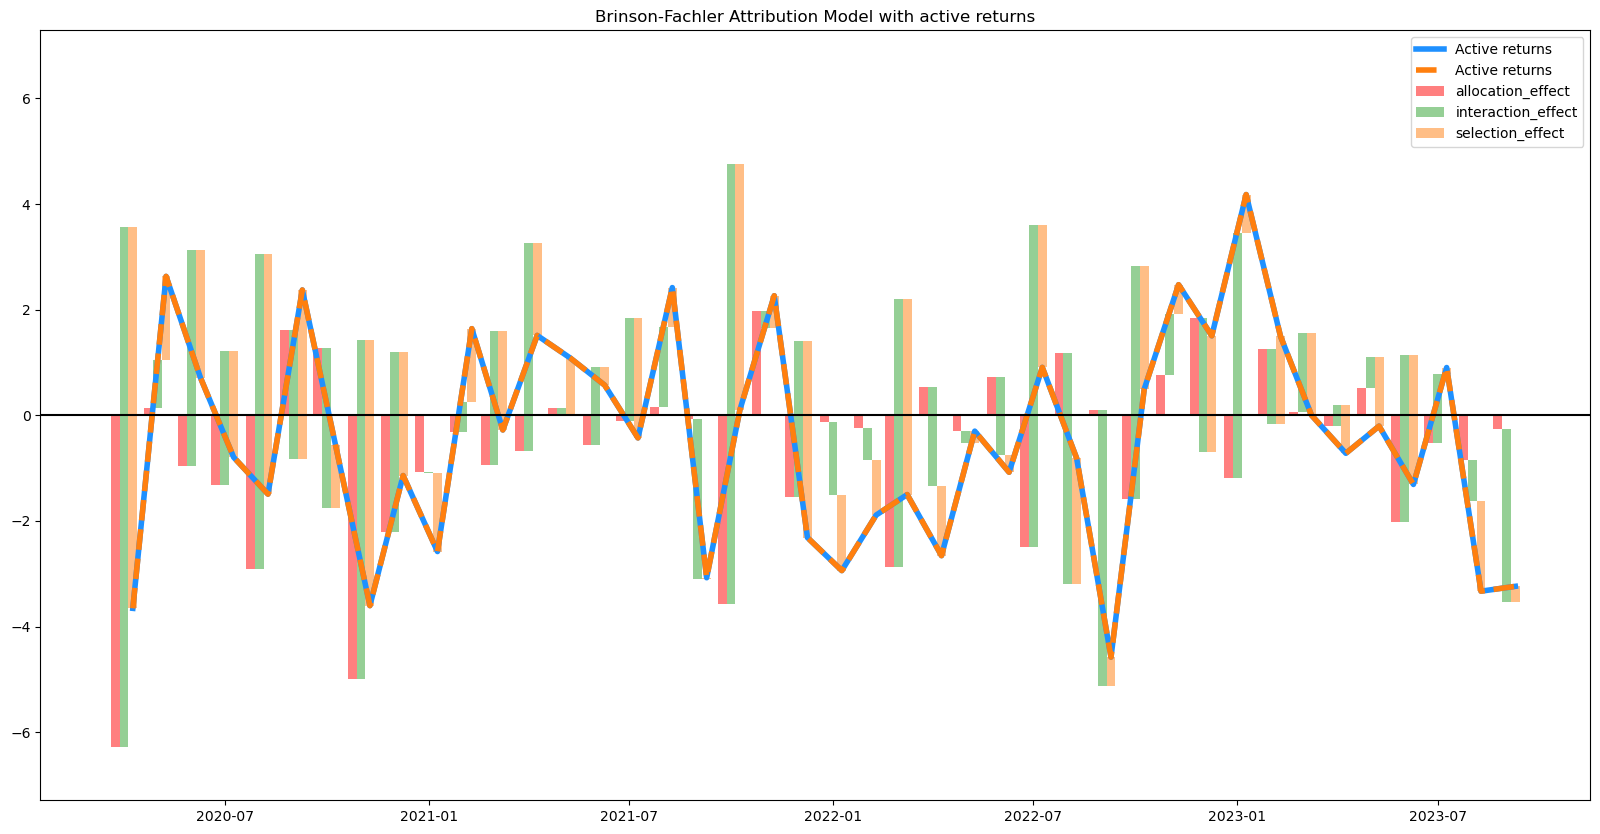

In [2438]:
AAE, SSE, IE = get_attribution_effects(weights_df, wRpi_within, wRbi_within, Rb, model='BF')
AAE = AAE.sum(axis=1)
SSE = SSE.sum(axis=1)
IE = IE.sum(axis=1)
attribution_df['sector_allocation_effect'] = AAE 
attribution_df['selection_effect'] = SSE
attribution_df['interaction_effect'] = IE
attribution_sum = AAE + SSE + IE

fig,ax = plt.subplots(figsize=(20,10))
ax.plot(Ra.index + dt.timedelta(8), Ra, 
        label='Active returns', linewidth=4, color='dodgerblue')
ax.plot(attribution_sum.index + dt.timedelta(8), attribution_sum, 
        label='Active returns', linewidth=4, color='tab:orange', linestyle='--')

ax.bar(x=AAE.index - dt.timedelta(8), 
        height=AAE, label='allocation_effect', 
        width=8, color='red', alpha=0.5)
ax.bar(x=IE.index,
        height=IE, bottom=AAE, label='interaction_effect', 
        width=8, color='tab:green', alpha=0.5)
ax.bar(x=SSE.index + dt.timedelta(8), 
        height=SSE, bottom=(AAE + IE), label='selection_effect', 
        width=8, color='tab:orange', alpha=0.5)

ax.set_ylim(-max(abs(ax.get_ybound()[0]), abs(ax.get_ybound()[1]))-1, max(abs(ax.get_ybound()[0]), abs(ax.get_ybound()[1]))+1)
ax.legend();
ax.axhline(0, c='black')
ax.set_title('Brinson-Fachler Attribution Model with active returns');

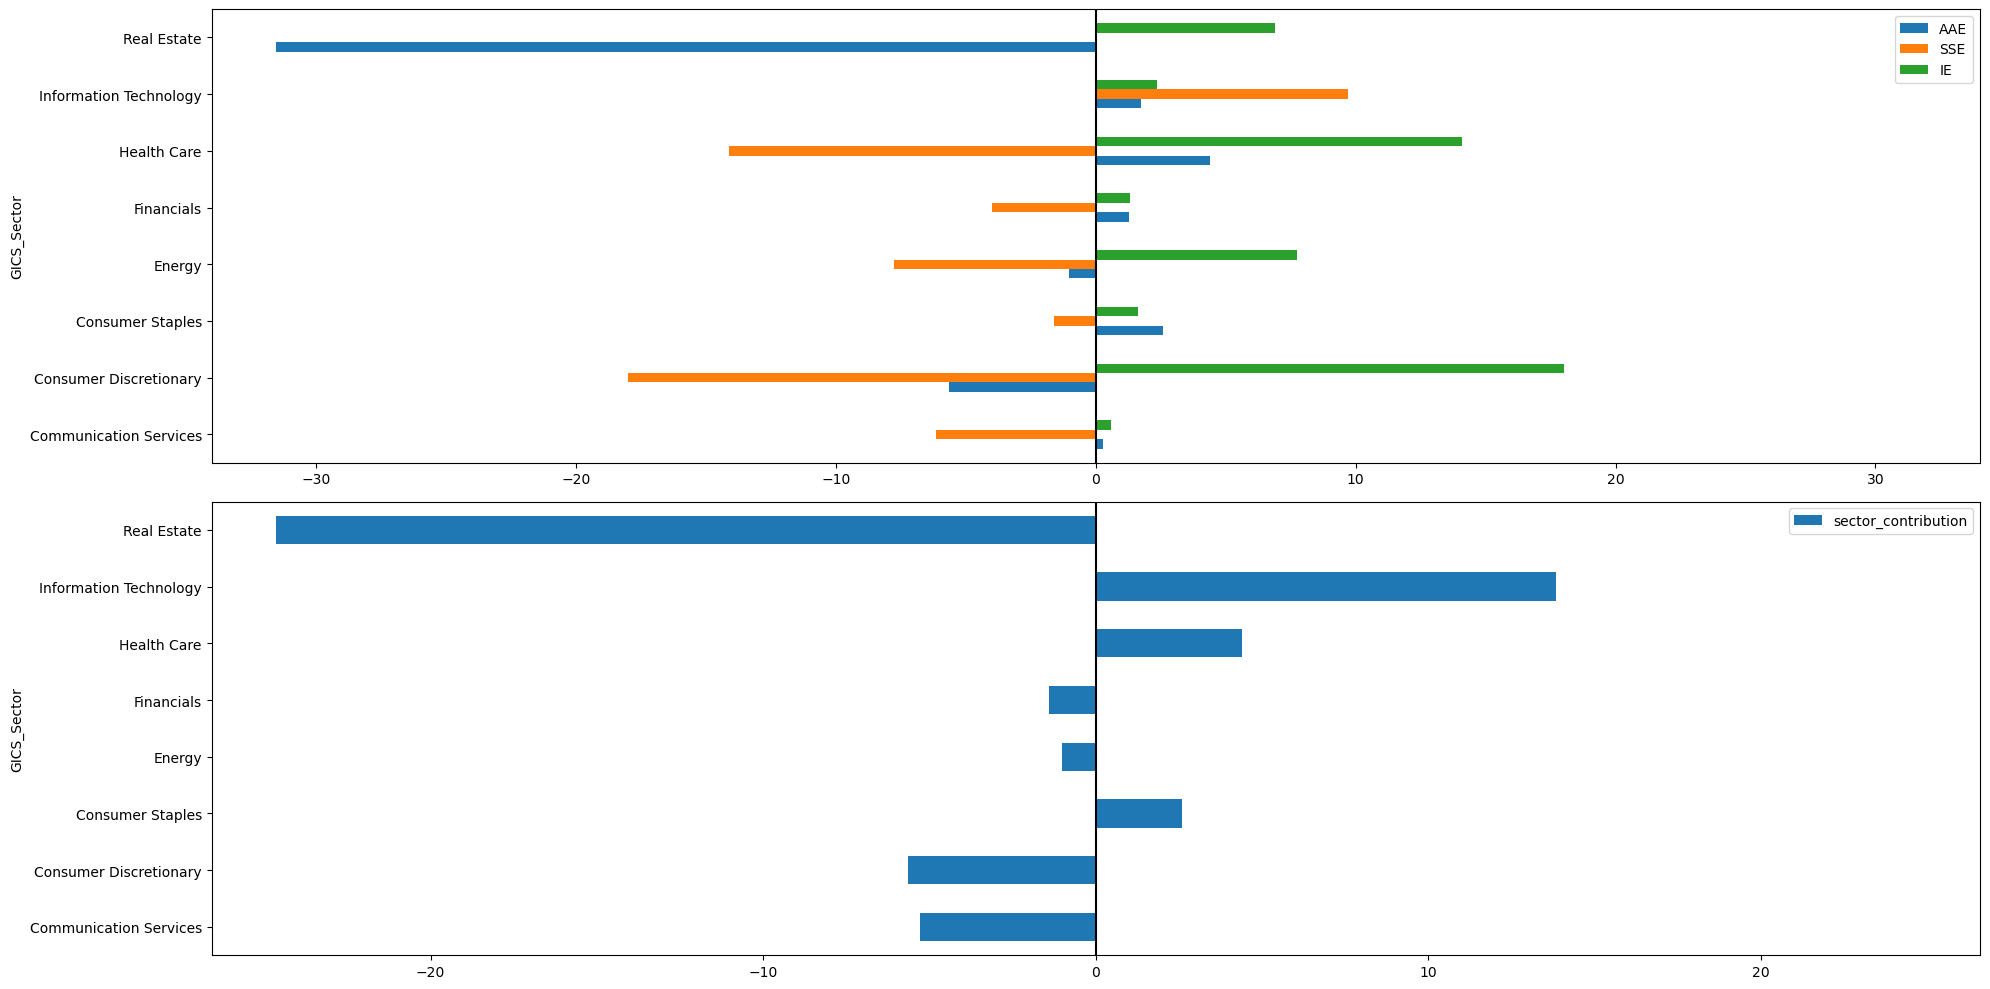

In [2439]:
AAE, SSE, IE = get_attribution_effects(weights_df, wRpi_within, wRbi_within, Rb, model='BF')
sector_df = sector_attribution(weights_df, AAE, SSE, IE)
    
fig,ax = plt.subplots(2,1, figsize=(20,10))
# return attribution
sector_df[['AAE','SSE','IE']].plot(kind='barh', ax=ax[0]);
# sector contribution to active returns
sector_df['sector_contribution'].plot(kind='barh', ax=ax[1])

for i in range(2):
    ax[i].axvline(0, c='black')
    ax[i].set_xlim(-max(abs(ax[i].get_xbound()[0]), abs(ax[i].get_xbound()[1])), max(abs(ax[i].get_xbound()[0]), abs(ax[i].get_xbound()[1])))
    ax[i].legend();
plt.tight_layout();

# real estate sector: realty income with highest weight dragged the return most due to increased risk in CRE and RE with rate hikes
# IT: pushed up active returns the most with the AI boom
# communication services & financials: underperformance in DIS and PYPL
# other sector contributions are due to not allocating the sector compared to benchmark which does allocate
# SSE seem to drag down the active returns heavily across sectors, though I did not allocate any into some of the sectors; nothing to select from
# --> interpretation is difficult for significantly unmatched portions with the Benchmark, i.e. entirely missing exposures
# e.g. I did not allocate on Cons discretionary, which resulted in negative active returns.

In [2440]:
weights_df.T[PF_w.keys()]

all_tkrs,O,NVDA,AAPL,MSFT,DIS,GOOGL,PYPL
PF_w,0.26,0.23,0.19,0.17,0.06,0.05,0.04
BM_w,0.0,0.098855,0.226507,0.129505,0.0,0.065173,0.0
a_w,0.26,0.131145,-0.036507,0.040495,0.06,-0.015173,0.04
GICS_Sector,Real Estate,Information Technology,Information Technology,Information Technology,Communication Services,Communication Services,Financials
PF_w_within,1.0,0.389831,0.322034,0.288136,0.545455,0.454545,1.0
BM_w_within,0.0,0.208304,0.477289,0.272889,0.0,0.5375,0.0


#### Systematic Risk adjusted return (alpha)

Using factor betas and factor risk premia (lambdas) over time for each assets, calculate:
$\alpha_{asset,t} = R_{actual} - E(R_{factor model})= R_{actual} - [R_{f} + \beta_{Mkt-RF}\lambda_{Mkt-RF} + \beta_{SMB}\lambda_{SMB} + \beta_{HML}\lambda_{HML} + \beta_{RMW}\lambda_{RMW} + \beta_{CMA}\lambda_{CMA}]$

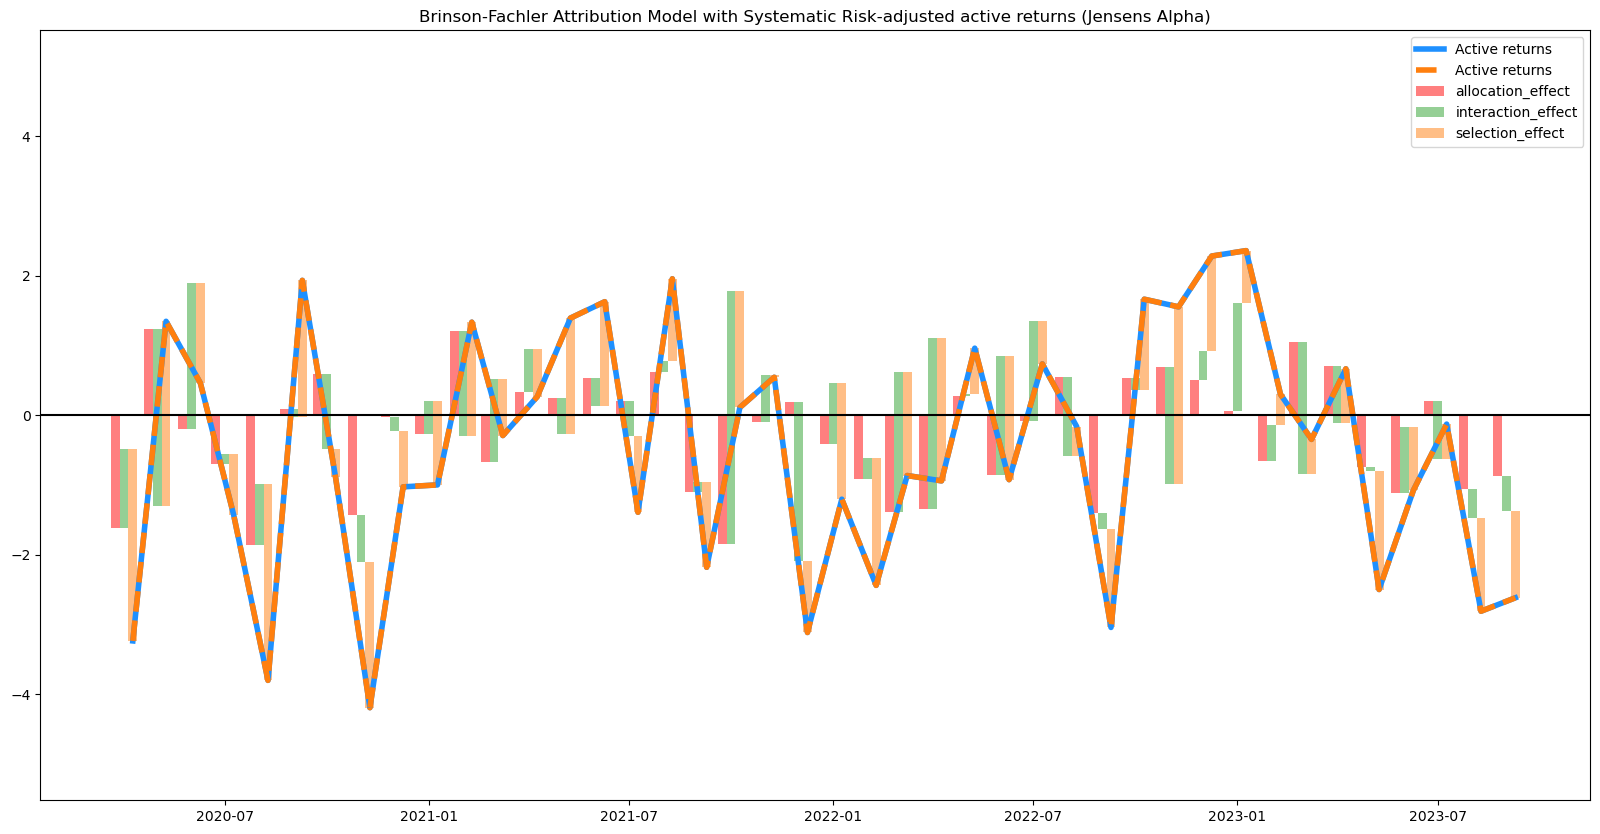

In [2441]:
All_returns = yf.download(tkrs_union, 
                          start=start, 
                          end=end, 
                          interval='1mo', progress=False)['Adj Close'].pct_change(1).dropna() * 100
U_exp_ret, U_alphas = get_alphas(All_returns, U_lambdas, U_betas)
All_returns = U_alphas

wRpi = All_returns * weights_df.PF_w
wRbi = All_returns * weights_df.BM_w
wRai = wRpi - wRbi

Rp = wRpi.sum(axis=1)
Rb = wRbi.sum(axis=1)
Ra = wRai.sum(axis=1)

wRpi_within, weights_df = get_sector_returns(All_returns, weights_df, pf='PF')
wRbi_within, weights_df = get_sector_returns(All_returns, weights_df, pf='BM')

AAE, SSE, IE = get_attribution_effects(weights_df, wRpi_within, wRbi_within, Rb, model='BF')
AAE = AAE.sum(axis=1)
SSE = SSE.sum(axis=1)
IE = IE.sum(axis=1)
attribution_df['sector_allocation_effect_alpha'] = AAE 
attribution_df['selection_effect_alpha'] = SSE
attribution_df['interaction_effect_alpha'] = IE
attribution_sum = AAE + SSE + IE

fig,ax = plt.subplots(figsize=(20,10))
ax.plot(Ra.index + dt.timedelta(8), Ra, 
        label='Active returns', linewidth=4, color='dodgerblue')
ax.plot(attribution_sum.index + dt.timedelta(8), attribution_sum, 
        label='Active returns', linewidth=4, color='tab:orange', linestyle='--')

ax.bar(x=AAE.index - dt.timedelta(8), 
        height=AAE, label='allocation_effect', 
        width=8, color='red', alpha=0.5)
ax.bar(x=IE.index,
        height=IE, bottom=AAE, label='interaction_effect', 
        width=8, color='tab:green', alpha=0.5)
ax.bar(x=SSE.index + dt.timedelta(8), 
        height=SSE, bottom=(AAE + IE), label='selection_effect', 
        width=8, color='tab:orange', alpha=0.5)

ax.set_ylim(-max(abs(ax.get_ybound()[0]), abs(ax.get_ybound()[1]))-1, max(abs(ax.get_ybound()[0]), abs(ax.get_ybound()[1]))+1)
ax.legend();
ax.axhline(0, c='black')
ax.set_title('Brinson-Fachler Attribution Model with Systematic Risk-adjusted active returns (Jensens Alpha)');

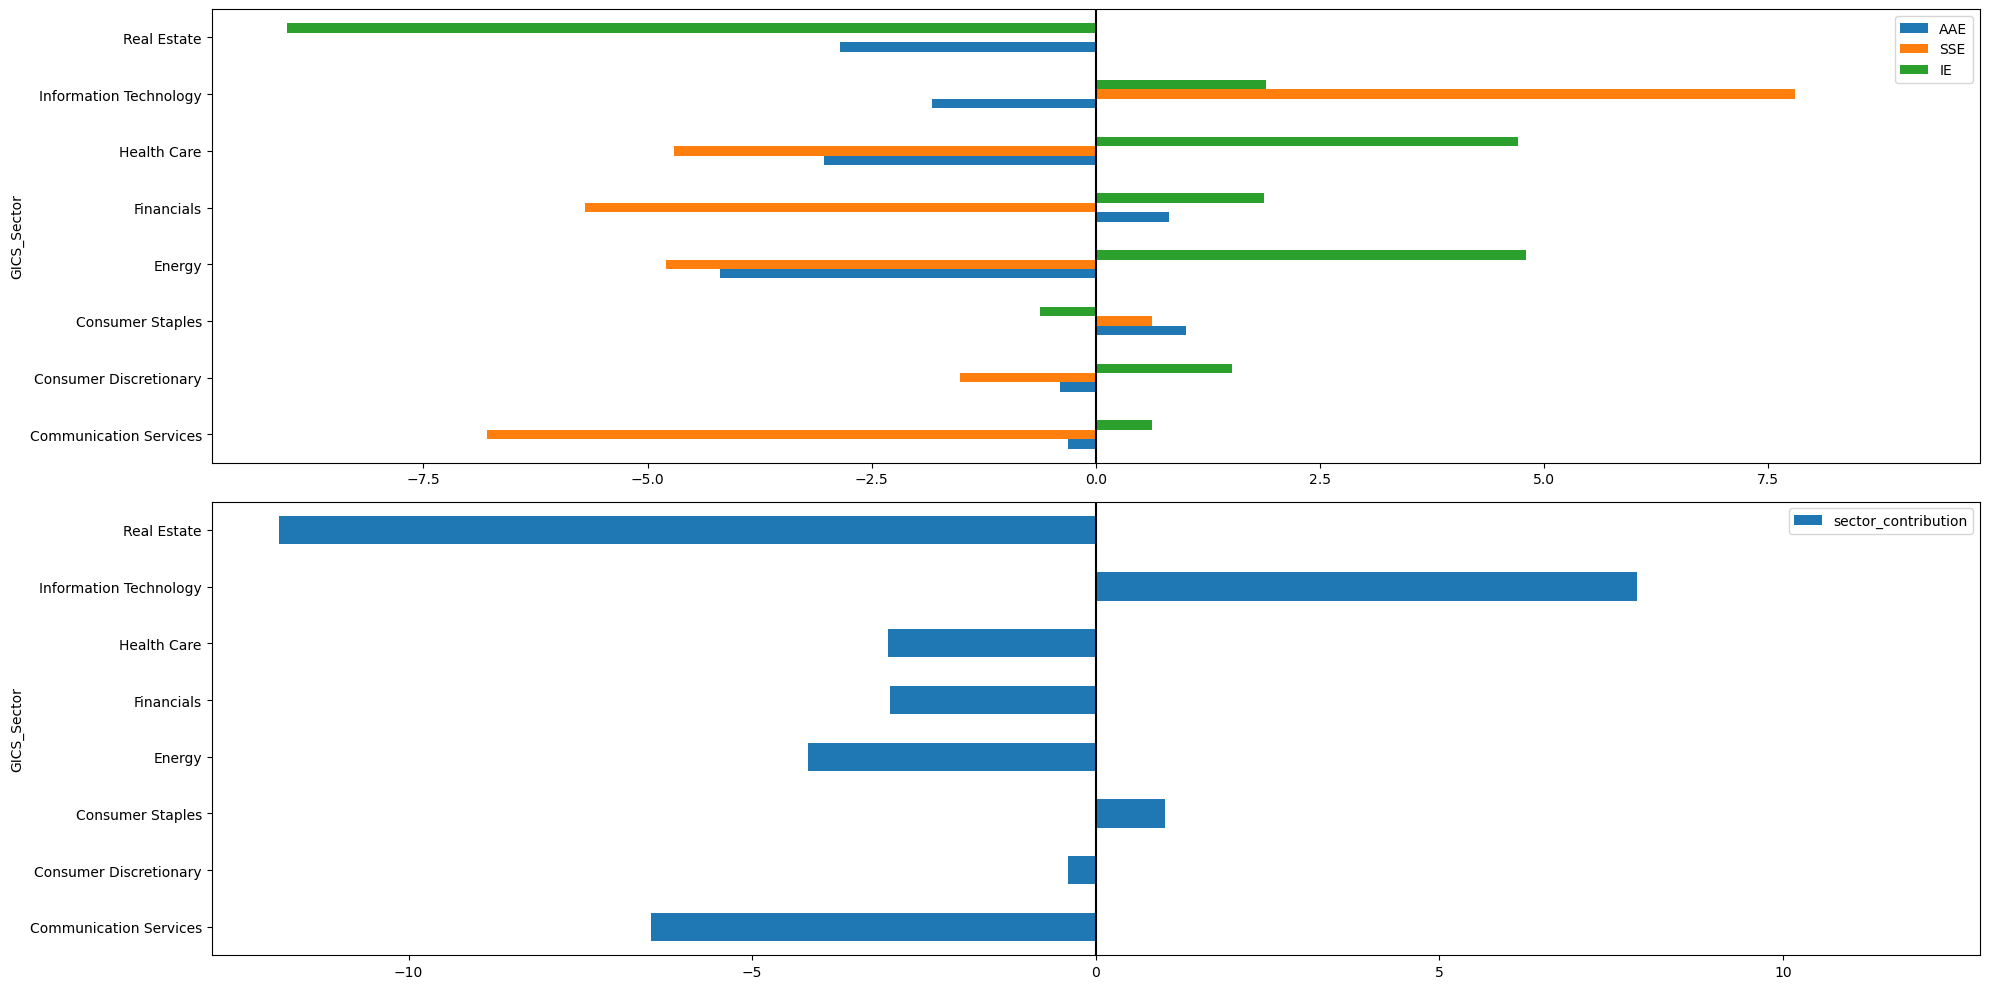

In [2442]:
AAE, SSE, IE = get_attribution_effects(weights_df, wRpi_within, wRbi_within, Rb, model='BF')
sector_df = sector_attribution(weights_df, AAE, SSE, IE)
    
fig,ax = plt.subplots(2,1, figsize=(20,10))
# return attribution
sector_df[['AAE','SSE','IE']].plot(kind='barh', ax=ax[0]);
# sector contribution to active returns
sector_df['sector_contribution'].plot(kind='barh', ax=ax[1])

for i in range(2):
    ax[i].axvline(0, c='black')
    ax[i].set_xlim(-max(abs(ax[i].get_xbound()[0]), abs(ax[i].get_xbound()[1])), max(abs(ax[i].get_xbound()[0]), abs(ax[i].get_xbound()[1])))
    ax[i].legend();
plt.tight_layout();
# alpha, on systematic risk-adjusted returns basis, still underperformed on RE and over performed in IT
# healthcare active returns turned negative and consumer discretionary less negative
# shows much significant dips for sectors that I did not allocate, i.e. healthcare and energy

#### Total Risk adjusted return (M-squared)

adjusting excess returns as if the portfolios where leveraged/underallocated to match total risk of market PF:

$M^{2} = (R_{p}-R_{f})\frac{\sigma_{m}}{\sigma_{p}} - (R_{m}-R_{f})$

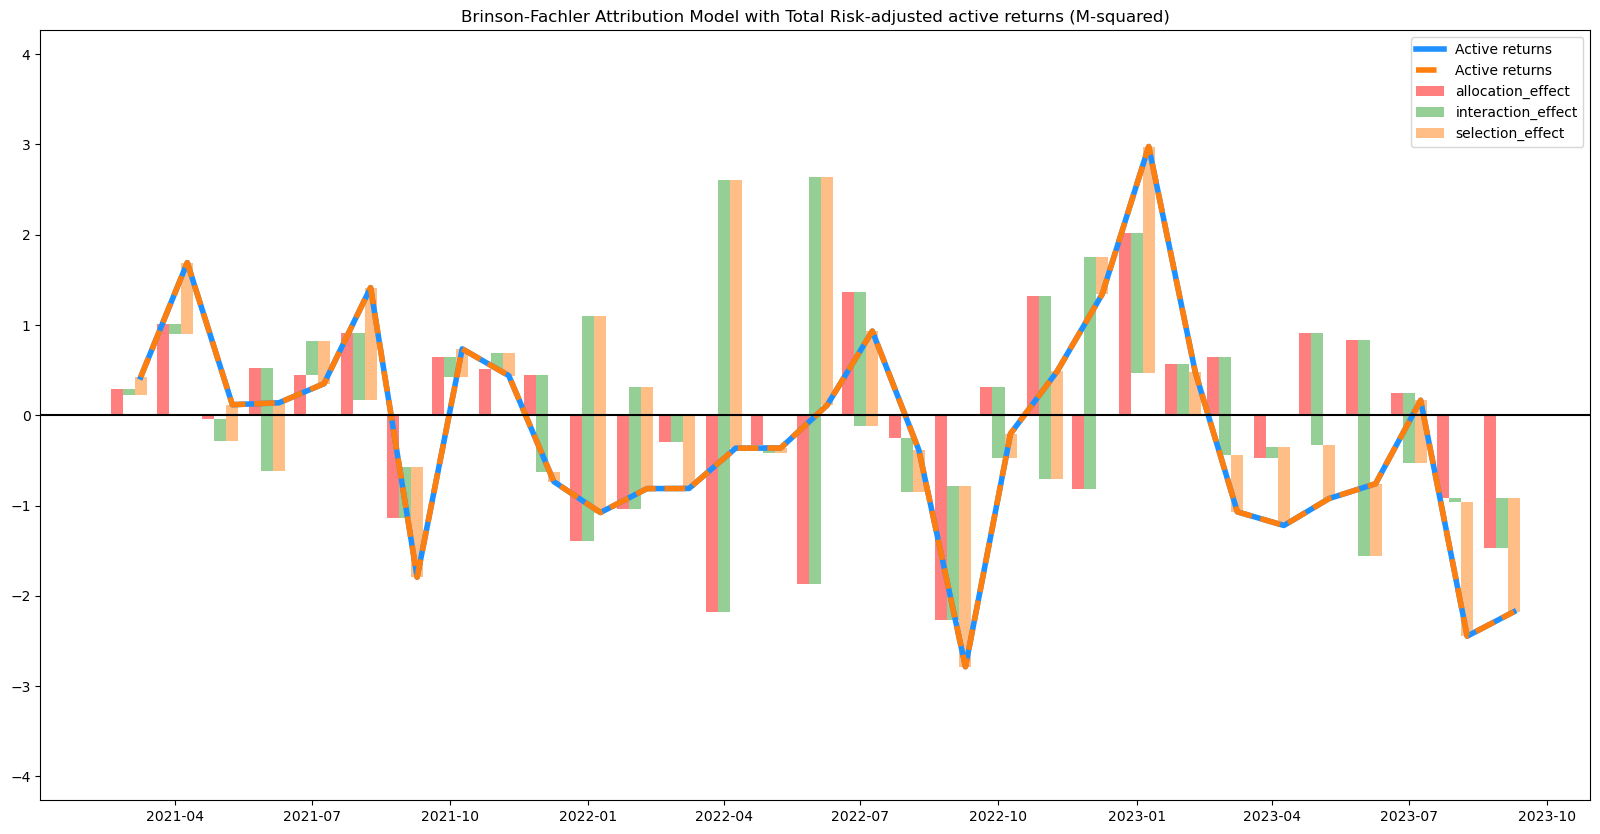

In [2443]:
All_returns = yf.download(tkrs_union, 
                          start=start, 
                          end=end, 
                          interval='1mo', progress=False)['Adj Close'].pct_change(1).dropna() * 100
All_returns = All_returns.apply(lambda x: get_M_sqs(Rm, x, ff_factor_data), axis=0).dropna()

wRpi = All_returns * weights_df.PF_w
wRbi = All_returns * weights_df.BM_w
wRai = wRpi - wRbi

Rp = wRpi.sum(axis=1)
Rb = wRbi.sum(axis=1)
Ra = wRai.sum(axis=1)

wRpi_within, weights_df = get_sector_returns(All_returns, weights_df, pf='PF')
wRbi_within, weights_df = get_sector_returns(All_returns, weights_df, pf='BM')

AAE, SSE, IE = get_attribution_effects(weights_df, wRpi_within, wRbi_within, Rb, model='BF')
AAE = AAE.sum(axis=1)
SSE = SSE.sum(axis=1)
IE = IE.sum(axis=1)
attribution_df['sector_allocation_effect_Msq'] = AAE 
attribution_df['selection_effect_Msq'] = SSE
attribution_df['interaction_effect_Msq'] = IE
attribution_sum = AAE + SSE + IE

fig,ax = plt.subplots(figsize=(20,10))
ax.plot(Ra.index + dt.timedelta(8), Ra, 
        label='Active returns', linewidth=4, color='dodgerblue')
ax.plot(attribution_sum.index + dt.timedelta(8), attribution_sum, 
        label='Active returns', linewidth=4, color='tab:orange', linestyle='--')

ax.bar(x=AAE.index - dt.timedelta(8), 
        height=AAE, label='allocation_effect', 
        width=8, color='red', alpha=0.5)
ax.bar(x=IE.index,
        height=IE, bottom=AAE, label='interaction_effect', 
        width=8, color='tab:green', alpha=0.5)
ax.bar(x=SSE.index + dt.timedelta(8), 
        height=SSE, bottom=(AAE + IE), label='selection_effect', 
        width=8, color='tab:orange', alpha=0.5)

ax.set_ylim(-max(abs(ax.get_ybound()[0]), abs(ax.get_ybound()[1]))-1, max(abs(ax.get_ybound()[0]), abs(ax.get_ybound()[1]))+1)
ax.legend();
ax.axhline(0, c='black')
ax.set_title('Brinson-Fachler Attribution Model with Total Risk-adjusted active returns (M-squared)');

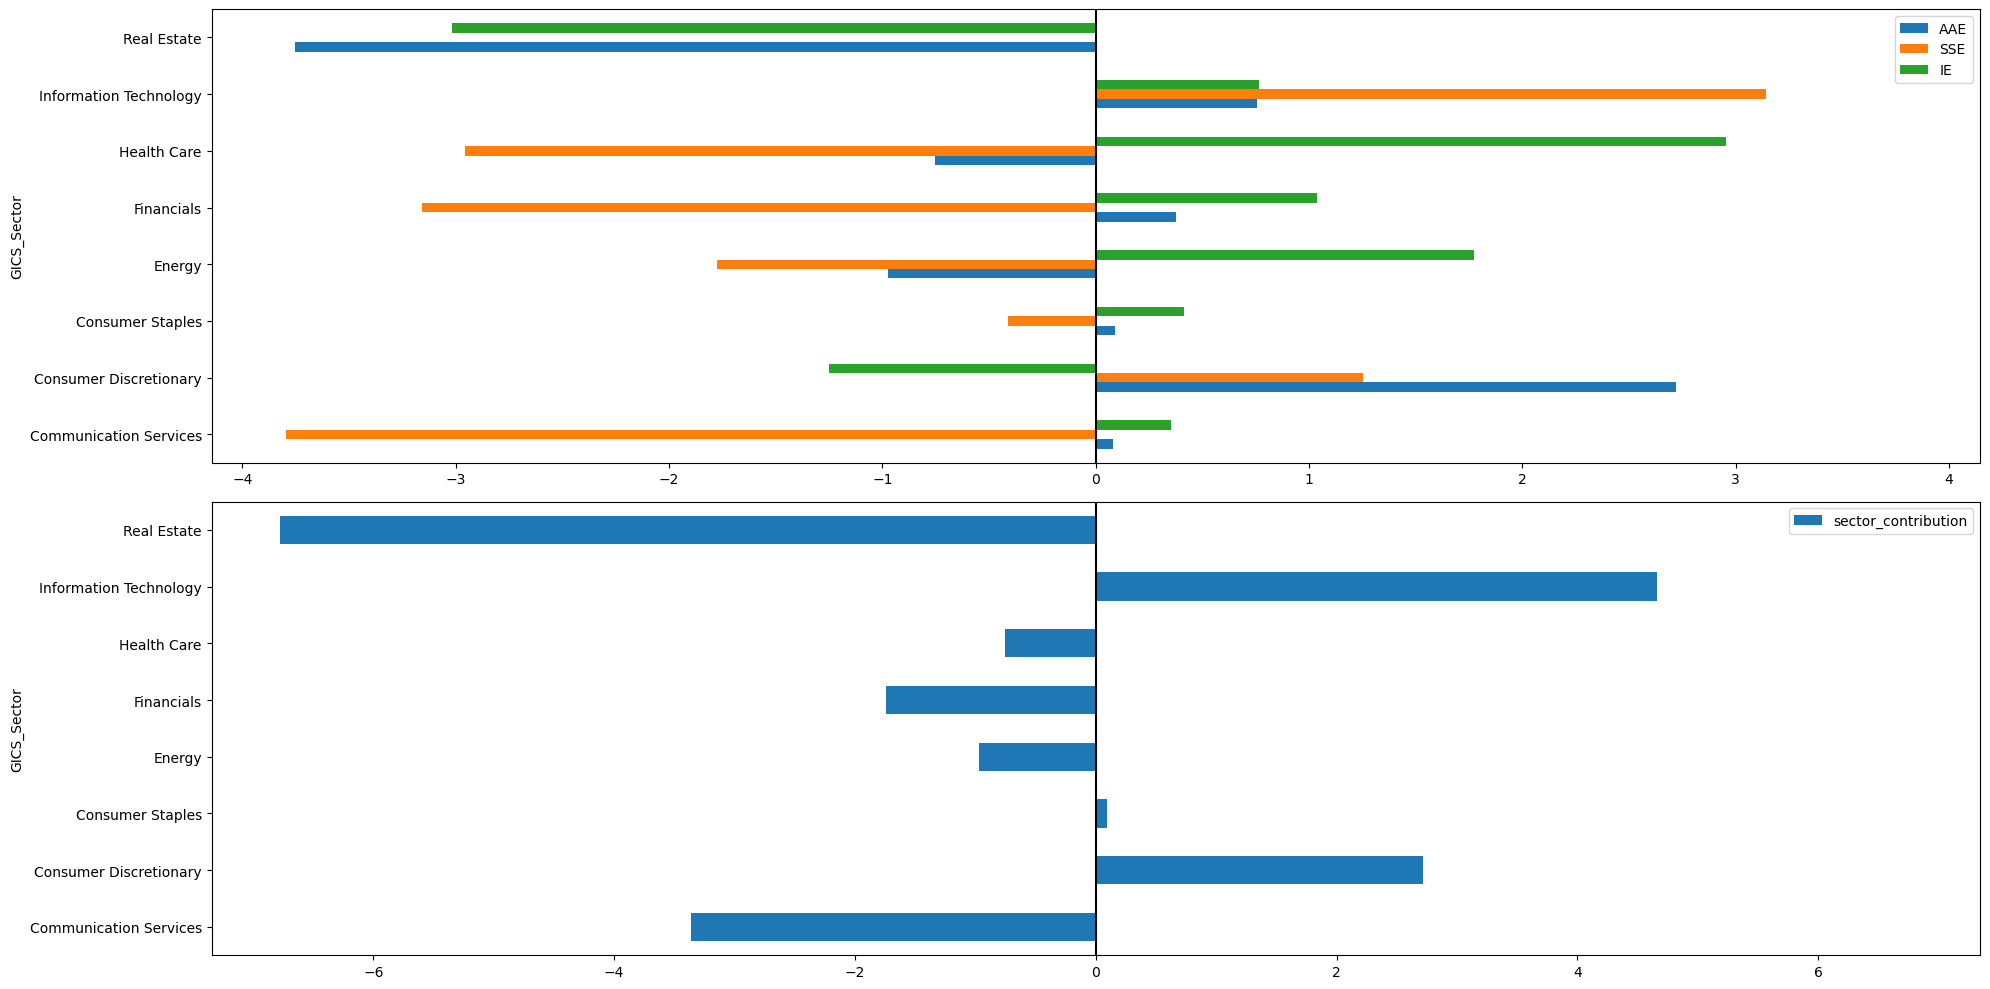

In [2444]:
AAE, SSE, IE = get_attribution_effects(weights_df, wRpi_within, wRbi_within, Rb, model='BF')
sector_df = sector_attribution(weights_df, AAE, SSE, IE)
    
fig,ax = plt.subplots(2,1, figsize=(20,10))
# return attribution
sector_df[['AAE','SSE','IE']].plot(kind='barh', ax=ax[0]);
# sector contribution to active returns
sector_df['sector_contribution'].plot(kind='barh', ax=ax[1])

for i in range(2):
    ax[i].axvline(0, c='black')
    ax[i].set_xlim(-max(abs(ax[i].get_xbound()[0]), abs(ax[i].get_xbound()[1])), max(abs(ax[i].get_xbound()[0]), abs(ax[i].get_xbound()[1])))
    ax[i].legend();
plt.tight_layout();

# M2, total risk-adjusted return basis, similar result as above but active returns for consumer diescretionary turned positive

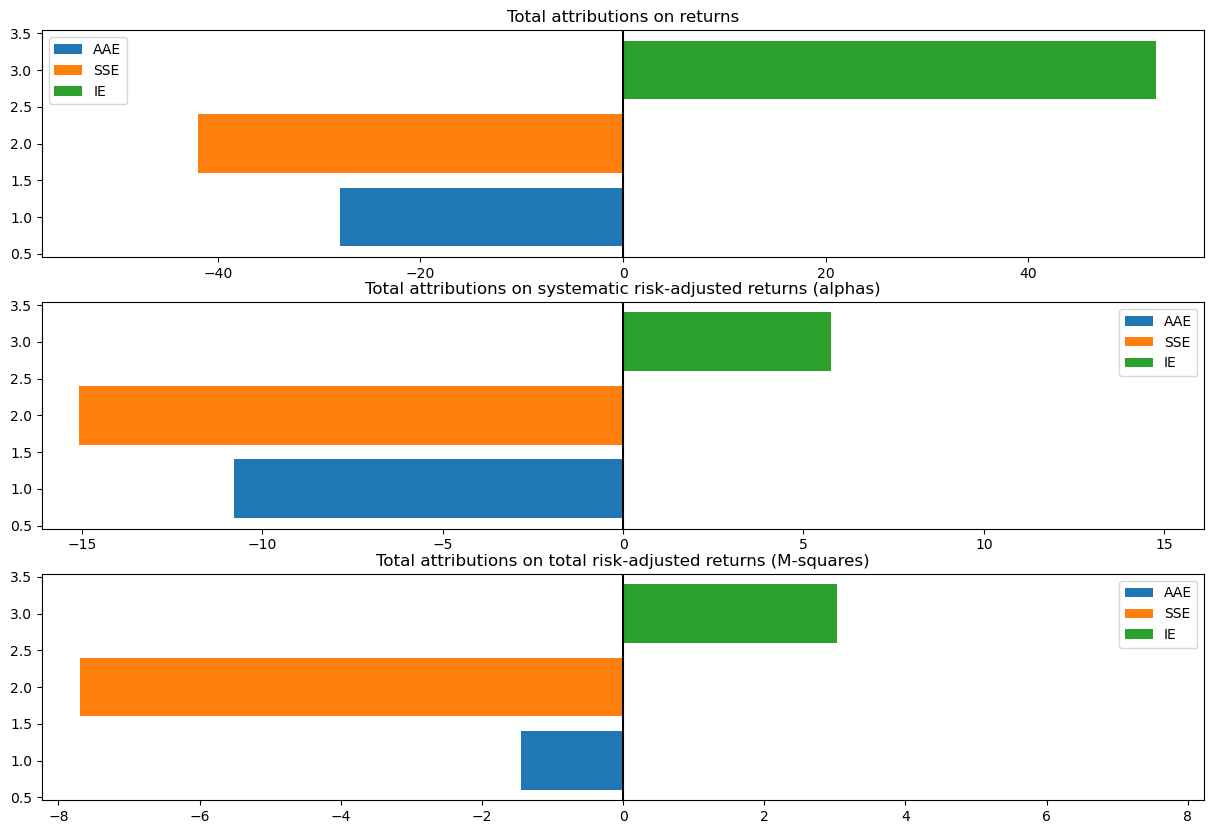

In [2445]:
fig,ax = plt.subplots(3,1, figsize=(15,10))
df_ = attribution_df[['sector_allocation_effect','selection_effect','interaction_effect']].sum()
ax[0].barh(width=df_[0], y=1, label='AAE')
ax[0].barh(width=df_[1], y=2, label='SSE');
ax[0].barh(width=df_[2], y=3, label='IE');
ax[0].set_title('Total attributions on returns')

df_ = attribution_df[['sector_allocation_effect_alpha','selection_effect_alpha','interaction_effect_alpha']].sum()
ax[1].barh(width=df_[0], y=1, label='AAE')
ax[1].barh(width=df_[1], y=2, label='SSE');
ax[1].barh(width=df_[2], y=3, label='IE');
ax[1].set_title('Total attributions on systematic risk-adjusted returns (alphas)')

df_ = attribution_df[['sector_allocation_effect_Msq','selection_effect_Msq','interaction_effect_Msq']].sum()
ax[2].barh(width=df_[0], y=1, label='AAE')
ax[2].barh(width=df_[1], y=2, label='SSE');
ax[2].barh(width=df_[2], y=3, label='IE');
ax[2].set_title('Total attributions on total risk-adjusted returns (M-squares)')

for i in range(3):
    ax[i].axvline(0, c='black')
    ax[i].set_xlim(-max(abs(ax[i].get_xbound()[0]), abs(ax[i].get_xbound()[1])), max(abs(ax[i].get_xbound()[0]), abs(ax[i].get_xbound()[1])))
    ax[i].legend();
    
# on risk-adjusted and unadjusted basis, return attribution seems to be similar in their overall conclusion:
# significantly negative contribution of SSE, less negative contribution of AAE, and positive residual effect IE